## Feature selection done by testing unsupervised methods and (supervised methods - not yet)

Feature selection is done after explorative data analysis. 
If potential groups of damage-influencing variables are clear than supervised techniques will be used, if underlying groups of variables are unknown than PCA (unsupervised method) is applied on the survey data to reduce mulitcollinearity.



In [165]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt


In [166]:
df_candidates = pd.read_excel("../../input_survey_data/survey_data_candidates_coords.xlsx")
df_candidates.tail(2)


,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,shp_damage_level_others,...,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,building_floor,lat,lon,geometry,elevation_m
502,2.0,70.0,2.0,10,0.0,2,2,4,2,0,...,1,1,10.0,2,1,1,106.628290,10.723266,POINT (106.62829 10.723266),4.0
503,0.0,100.0,5.0,20,0.0,2,1,1,1,0,...,1,2,50.0,3,3,0,106.626656,10.716209,POINT (106.626656 10.716209),3.0


In [167]:
# ## clean df from few nan values

#print(df_candidates.isna().sum())
df_candidates = df_candidates.replace(np.nan, 0)
#X.info()

In [174]:
y = df_candidates.Target_direct.astype("int64")
X = df_candidates.drop(["Target_direct",
                        "shp_damage_level_others_r.specify", "shp_damage_level_others_s.specify",
                        #"shp_sector.specify",   # fix this variable and make as numerbs
                        "Q0.1",
                        "geometry","lat","lon"
                        ], axis=1)



In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)


## classes have to start from zero on
le = LabelEncoder()
y_train = le.fit_transform(y_train)


In [176]:
param_dist = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [1, 3, 5, 10,20],
              'colsample_bynode': [0.1, 0.3] # nbr of feautres for each split point
              #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
              }



In [181]:
model = XGBClassifier() 
model.fit(X_train, y_train)

model_rs = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=3,  # add cv=5 again as soon scarce samples are removed
                                 #scoring='roc_auc',n_jobs=-1,verbose=3
                                 )

                                 ## TODO remove from target samples which occure less thn one time
                                

# Fit the model by randomizedSearchCV
model_rs.fit(X_train, y_train)


## predict unseen X_test set
y_pred = model_rs.predict(X_test)

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwarg

### Evaluation

In [179]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:  {accuracy*100:.2f}%")  


Accuracy:  67.33%


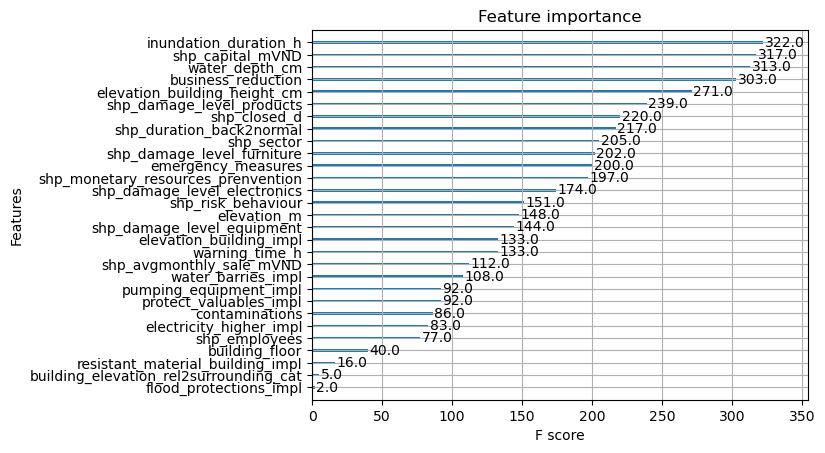

In [183]:
# plot feature importance
plot_importance(model)
plt.show()

In [152]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
------------------------------------------------

NameError: name 'mean' is not defined